# Part 2 : Transport of N2 in the Counterflow Configuration

In this notebook, we will: 
- Import the parameters from config.py
- Build the grid from grid.py
- Calculate the velocity field u(x,y,t),v(x,y,t) via fractional step (navier_stokes.py)
- Solve the transport equation for a passive species (N2) : $\frac{\partial Y}{\partial t} + \textbf{u} \nabla Y = D \Delta Y$
- Visualize the evolution of the mass field YN2

In [2]:
import os
import sys

# Adjust path so Python can find ../src
project_root = os.path.abspath("..")
src_path = os.path.join(project_root, "src")

if src_path not in sys.path:
    sys.path.append(src_path)

print("Added to PYTHONPATH:", src_path)

import numpy as np
import matplotlib.pyplot as plt

from counterflow.config import default_params
from counterflow.grid import create_grid
from counterflow.navier_stokes import V0_cond, fractional_step
from counterflow.transport import YN2_0, calcul_YN2

Added to PYTHONPATH: /Users/emma.grospellier/Final-project-M2-Combustion-of-methane-in-a-countercurrent-configuration/src


In [3]:
params = default_params()

Nx = params["Nx"]
dt = params["dt"]
Tf = params["Tf"]
Nt = params["Nt"]
nu = params["nu"]
rho = params["rho"]
D  = params["D"]

print("Parameters loaded:")
for k,v in params.items():
    print(f"{k}: {v}")

x, y, dx, dy = create_grid(params["Lx"], Nx)

print("Grid:")
print(" dx =", dx, " dy =", dy)

Parameters loaded:
rho: 1.1614
nu: 1.5e-05
D: 1.5e-05
cp: 1200
Lx: 0.002
Ly: 0.002
Nx: 50
Ny: 50
Tf: 0.01
Nt: 3000
dt: 3.334444814938313e-06
Grid:
 dx = 4.0816326530612245e-05  dy = 4.0816326530612245e-05


In [9]:
# CFL condition check 
u_max = np.max(np.abs(u))
v_max = np.max(np.abs(v))

CFL = max(u_max * dt / dx, v_max * dt / dy)
if CFL < 1:
    print("CFL < 1 : stable condition")
else:
    print("CFL > 1 : scheme might be unstable")

CFL < 1 : stable condition


In [4]:
U0 = np.zeros(Nx*Nx)
V0 = V0_cond(Nx)
P0 = np.zeros(Nx*Nx)

p, u, v = fractional_step(U0, V0, P0, dt, dx, nu, Nt, Nx, rho)

Condition number: 34607994010.898506


In [6]:
YN2_calc, time = calcul_YN2(u, v, YN2_0, dt, dx, D, Nt, Nx, rho)

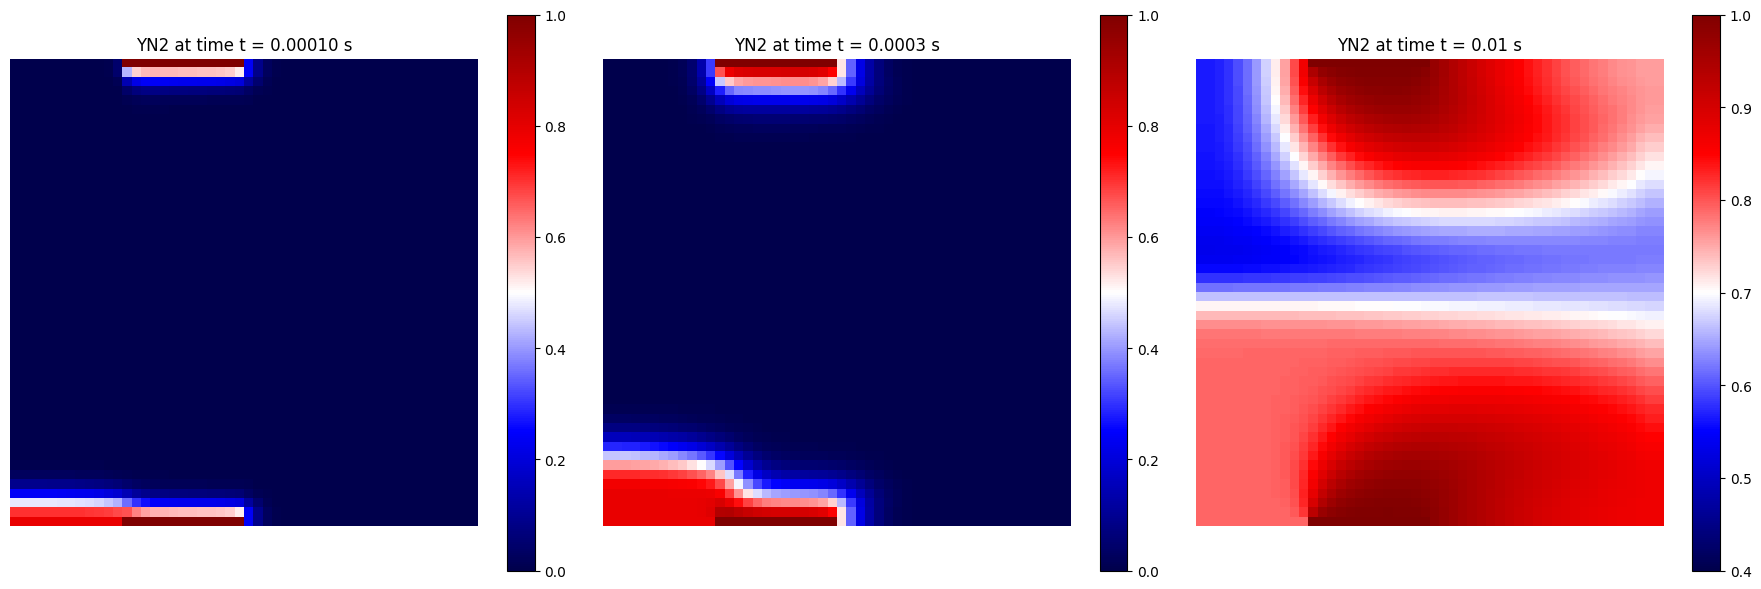

In [7]:
# Time evolution of YN2 

fig2, axs2 = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

im12 = axs2[0].imshow(np.reshape(YN2_calc, (Nx, Nx, 4))[:, :, 1], cmap='seismic')
axs2[0].set_title(f"YN2 at time t = {time[1]:.5f} s")
axs2[0].invert_yaxis()
axs2[0].axis('off')
fig2.colorbar(im12, ax=axs2[0])

im21 = axs2[1].imshow(np.reshape(YN2_calc, (Nx, Nx, 4))[:, :, 2],cmap='seismic')
axs2[1].set_title(f"YN2 at time t = {time[2]:.4f} s")
axs2[1].invert_yaxis()
axs2[1].axis('off')
fig2.colorbar(im21, ax=axs2[1])

im32 = axs2[2].imshow(np.reshape(YN2_calc, (Nx, Nx, 4))[:, :, 3],cmap='seismic',vmin=0.4, vmax=1.0)
axs2[2].set_title(f"YN2 at time t = {time[3]:} s")
axs2[2].invert_yaxis()
axs2[2].axis('off')
fig2.colorbar(im32, ax=axs2[2])

plt.tight_layout()
plt.show()


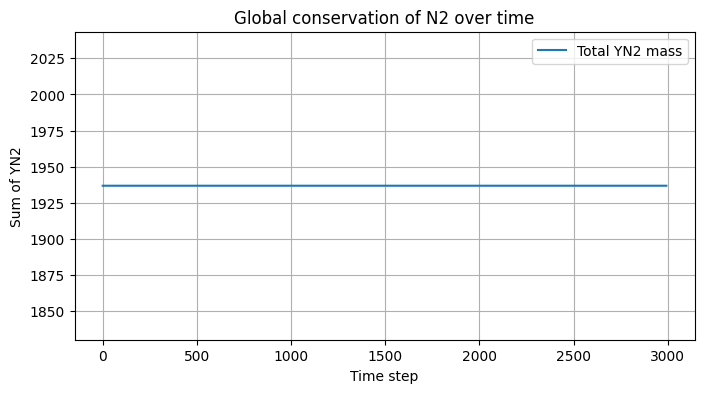

In [13]:
# Conservation check of YN2 

# Compute total YN2 mass in time
mass_YN2 = np.zeros(Nt)
for n in range(Nt):
    mass_YN2[n] = np.sum(YN2_calc[:, n % 4] if n in [0,30,100,Nt-1] else YN2_calc[:, -1])
mass_clean = mass_YN2[mass_YN2 > 250]

plt.figure(figsize=(8,4))
plt.plot(mass_clean[3:], label="Total YN2 mass")
plt.xlabel("Time step")
plt.ylabel("Sum of YN2")
plt.grid(True)
plt.title("Global conservation of N2 over time")
plt.legend()
plt.show()


The N2 field behaves as expected: it is injected from the boundaries and gradually transported and diffused by the velocity field. At longer times, the profile stabilizes in a stratified distribution aligned with the counterflow structure.

In [15]:
#save datas
np.save("../data/YN2.npy", YN2_calc)